In [11]:
#Load all libraries
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc, RocCurveDisplay, precision_recall_curve
from sklearn import metrics
from numpy import interp
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import cross_validate
import pprint 
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.exceptions import UndefinedMetricWarning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.ensemble import RandomForestClassifier

#Load data
X_internal = pd.read_csv('X_internal_featuresselected_NB3Y_NS.csv', index_col=0)
y_internal = pd.read_csv('y_internal_featuresselected_NB3Y_NS.csv', index_col=0)

var_to_drop = ['VR', 'DR', 'CRTD', 'SICD', 'Ventricular Heart Rate', 'Atrial Heart Rate', 'PR Interval', 'QRS Duration', 'QT Interval', 'RR Interval', 'QTc Interval', 'QTc Bazett', 'R Axis', 'T Axis', 'QRS Axis']
X_internal = X_internal.drop(var_to_drop, axis=1)

In [14]:
#Hyperparameter tuning
cv_ht = KFold(n_splits=3, shuffle=True, random_state=42)
cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42)


In [6]:
'''''
Training data using k-fold repeated cross-validation

Step 1. Pick the model you want to train based on the value 1 (Support Vector Machine) or 2 (Extreme Gradient Boosting) or 3 (Random Forests)
Step 2. Grid search the model based on the parameter grid that is provided
Step 3. Save the trained model
'''''

modelpick = 2 #1 SVM 2 XGB 3 RF

if modelpick == 1:
    SVM = svm.SVC(probability=True)
    random_grid = {'C': [0.01, 0.1,1,5,10,100,200,500], 'gamma': [10,1,0.1,0.075,0.05,0.01,0.001,0.005,0.0001],'kernel': ['rbf', 'poly', 'sigmoid']}
    grid_model = GridSearchCV(estimator = SVM, scoring="roc_auc", param_grid = random_grid, cv = cv_ht, verbose=0, n_jobs = 1)
    grid_model.fit(X_internal, (np.ravel(y_internal)))
    model_tuned = grid_model.best_estimator_
    print(grid_model.best_params_)
elif modelpick ==2:
    classifier = xgb.XGBClassifier()
    params = {'learning_rate': [0.01, 0.05,0.10,0.20], 'max_depth': [3,6,9,12,14], 
              'min_child_weight': [1, 3, 5, 7, 9], 'gamma': [0.0,0.2,0.4, 0.6], 'colsample_bytree': [0.3,0.5,0.7, 0.9]}
    grid_model=GridSearchCV(classifier,param_grid=params, scoring='roc_auc',n_jobs=1,cv=cv_ht,verbose=0)
    grid_model.fit(X_internal, y_internal)
    model_tuned = grid_model.best_estimator_
    print(grid_model.best_params_)
elif modelpick == 3:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
    grid_model=GridSearchCV(rfc, param_grid=param_grid, scoring='roc_auc',n_jobs=1,cv=cv_ht,verbose=0)
    grid_model.fit(X_internal, (np.ravel(y_internal)))
    model_tuned = grid_model.best_estimator_
    print(grid_model.best_params_)

# #Cross validation
from cross_val import cross_val

y_internal = np.ravel(y_internal)

cross_validation_results = cross_val(model_tuned, X_internal, y_internal, n_repeats=1, n_splits=10)
print(cross_validation_results)

In [12]:
Save the trained model as a pickle string.
import pickle
model_name = 'NB3y_xgb_selectedclinical.pkl'
path = '\MODELS\'

# Load the pickled model
import pickle
model_name = 'NB3y_xgb_selectedclinical.pkl'
path = '\MODELS\'
import os
model_path = os.path.join(path, model_name)
with open(model_path, 'rb') as f:
    model_tuned = pickle.load(f)

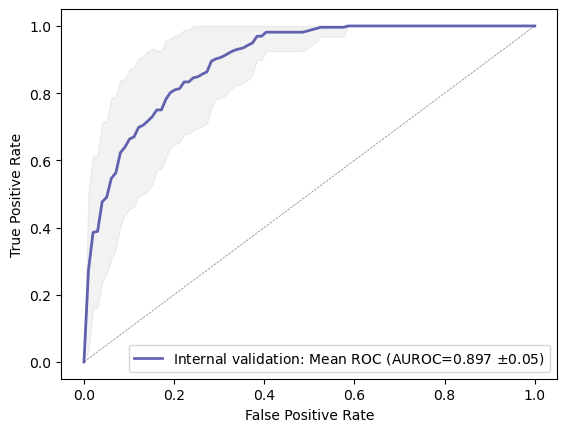

In [16]:
from draw_cv_roc_curve import draw_cv_roc_curve
X_internal = pd.DataFrame(X_internal)
y_internal = pd.DataFrame(y_internal)
draw_cv_roc_curve(model_tuned, cv, X_internal, y_internal)

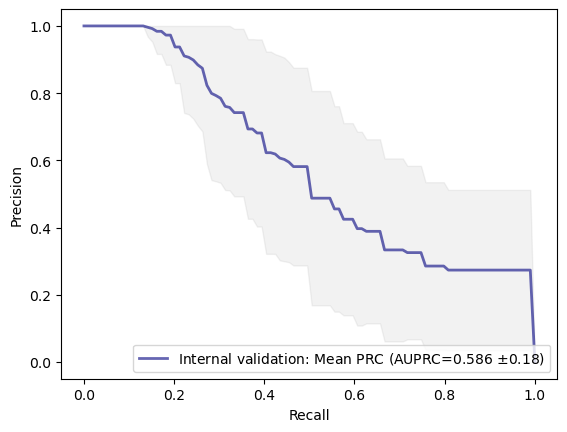

In [17]:
from draw_cv_pr_curve import draw_cv_pr_curve
X_internal = pd.DataFrame(X_internal)
y_internal = pd.DataFrame(y_internal)
draw_cv_pr_curve(model_tuned, cv, X_internal, y_internal)

In [18]:
'''''
Validate the model on the external dataset
Step 1. Load the pickled model and the internal datasets
Step 2. The relevant columns are selected from the External dataset 
Step 3. The Youden and Recall index are calculated, final predictions are based on the Youden threshold 

'''''

def sensivity_specifity_cutoff(y_true, y_score):
    import numpy as np
    from sklearn.model_selection import RepeatedStratifiedKFold
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]
def recall_cutoff(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    idx = np.argmax(fscore)
    return thresholds[idx]  
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from modelling_ecg import *
from sklearn.metrics import roc_auc_score

# Load the pickled model
import pickle
model_name = 'NB3y_xgb_selectedclinical.pkl'
path = '\MODELS\'
import os
model_path = os.path.join(path, model_name)
with open(model_path, 'rb') as f:
    model_tuned = pickle.load(f)
    
#Get those relevant columns from the X_external as well
X_external = pd.read_csv('X_external_3Y_NS.csv',index_col=0)
y_external = pd.read_csv('y_external_3Y_NS.csv',index_col=0)
y_external = y_external['ICDnonbenefit_3Y']

#Get the features selected in developmentset
columns_needed_X_external = list(X_internal)
X_external = X_external[columns_needed_X_external]
print(X_external.shape)
model_tuned.fit(X_internal, y_internal)

#Get the probabilities of prediction in external dataset
y_prob = model_tuned.predict_proba(X_external)[:, 1]

youden_index = ((sensivity_specifity_cutoff(y_external, y_prob)))
recall_index = ((recall_cutoff(y_external, y_prob)))
print('Youden index:', youden_index)
print('Recall index:', recall_index)
y_pred = model_tuned.predict_proba(X_external)[:, 1] >= youden_index

(460, 85)
Youden index: 0.021935876
Recall index: 0.84386176


In [ ]:
##Save the probabilities
y_prob_df = pd.DataFrame(y_prob)
y_prob_df.to_csv('y_prob_df_NB3Y_NS.csv')

##Save the predictions
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.to_csv('y_pred_df_NB3Y_NS.csv')

<function matplotlib.pyplot.show(close=None, block=None)>

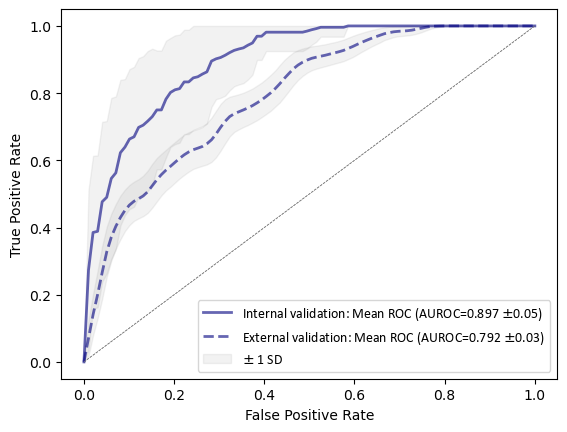

In [19]:
'''''
Bootstrap (2000 iterations) to get CI 95% around the AUROC for the external test-set predictions
'''''

import numpy as np
from pandas import read_csv
from sklearn.utils import resample
from matplotlib import pyplot
from sklearn.metrics import average_precision_score
from numpy import mean
from draw_cv_roc_curve import draw_cv_roc_curve
from sklearn.metrics import precision_score, recall_score
import aif360.sklearn.metrics as af
from sklearn.metrics import roc_auc_score

X_internal = pd.DataFrame(X_internal)
y_internal = pd.DataFrame(y_internal)
draw_cv_roc_curve(model_tuned, cv, X_internal, y_internal)

# load dataset
data = X_external.join(y_external)
values = data.values

# configure bootstrap
n_iter = 2000
n_iterations = n_iter
n_size = int(len(data) * 0.60)

#Run bootstrap for the AUROC
youden_index = 0.021935876
stats = list()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
f1_list = []
recall_list = []
precistion_list = []
accuracy_list = []
specificity_list = []
for i in range(n_iterations):
    # prepare train and test sets
    train = resample(values, n_samples=n_size)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])
    # fit model
    model_tuned.fit(X_internal, y_internal)
    # evaluate model
    predictions = model_tuned.predict_proba(test[:,:-1])[:, 1]
    predictions_youden = predictions >= youden_index
    score = roc_auc_score(test[:,-1], predictions)
    stats.append(score)
    fpr, tpr, threshold = metrics.roc_curve(test[:,-1], predictions)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    f1 = metrics.f1_score(test[:,-1], predictions_youden, labels=None, pos_label=1, average='weighted')
    f1_list.append(f1)
    recall = recall_score(test[:,-1], predictions_youden, average='micro')
    recall_list.append(recall)
    precision = precision_score(test[:,-1], predictions_youden, average='micro')
    precistion_list.append(precision)
    accuracy = metrics.accuracy_score(test[:,-1], predictions_youden, normalize=True, sample_weight=None)
    accuracy_list.append(accuracy)
    specificity = af.specificity_score(test[:,-1], predictions_youden)
    specificity_list.append(specificity)

mean_f1 = (mean(f1_list))  
f1_std = np.std(f1_list)
f1_ci = np.percentile(f1_list, [2.5, 50, 97.5])
print("Mean bootstrapped F1 is:", mean_f1, "SD", f1_std, "CI", f1_ci)

mean_recall = (mean(recall_list))
recall_std = np.std(recall_list)
recall_ci = np.percentile(recall_list, [2.5, 50, 97.5])
print("Mean bootstrapped sensitivity is:", mean_recall, "SD", recall_std, "CI", recall_ci)

mean_precision = (mean(precistion_list))
precision_std = np.std(precistion_list)
precision_ci = np.percentile(precistion_list, [2.5, 50, 97.5])
print("Mean bootstrapped precision is:", mean_precision, "SD", precision_std, "CI", precision_ci)

mean_specificity= (mean(specificity_list))
specificity_std = np.std(specificity_list)
specificity_ci = np.percentile(specificity_list, [2.5, 50, 97.5])
print("Mean bootstrapped specificity is:", mean_specificity, "SD", specificity_std, "CI", specificity_ci)

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
mean_auroc = (mean(stats))
mean_auroc = round(mean_auroc,3)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
#r'Internal validation: Mean ROC (AUROC=%0.3f $\pm$ %0.3f)' 
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='navy', linestyle='--', label=r'External validation: Mean ROC (AUROC=%0.3f $\pm$%0.2f)' % (mean_auc, std_auc), lw=2, alpha=.6)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.plot([0, 1], [0, 1], linestyle='--', color = "grey", lw=0.5)
plt.rcParams['font.family'] = "calibri"
ci_95 = ('95%% CI: %.3f-%.3f' % (lower, upper))
print(ci_95)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1, label=r'$\pm$ 1 SD')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.rcParams["figure.dpi"] = 100

plt.savefig('AUROC_NB3Y_NS.pdf', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

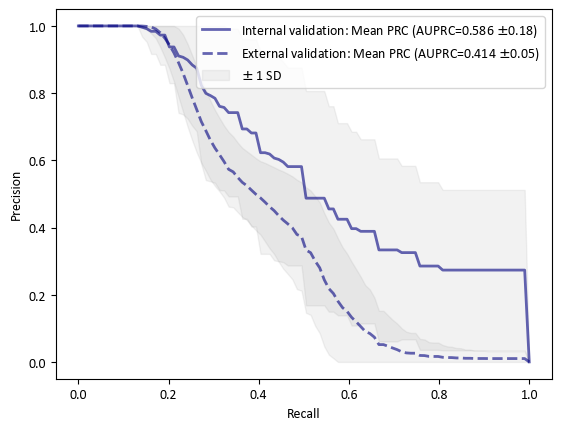

In [20]:

'''''
Bootstrap (2000 iterations) to get CI 95% around the AUPRC for the external test-set predictions
'''''

import numpy as np
from pandas import read_csv
from sklearn.utils import resample
from matplotlib import pyplot
from sklearn.metrics import average_precision_score
from numpy import mean
from sklearn.metrics import precision_recall_curve


from draw_cv_pr_curve import draw_cv_pr_curve
X_internal = pd.DataFrame(X_internal)
y_internal = pd.DataFrame(y_internal)
draw_cv_pr_curve(model_tuned, cv, X_internal, y_internal)

# load dataset
data = X_external.join(y_external)
values = data.values

# configure bootstrap
n_iterations = 2000
n_size = int(len(data) * 0.60)

#Run bootstrap for the AUROC
stats = list()
prs = []
aucs = []
mean_recall = np.linspace(0, 1, 100)

for i in range(n_iterations):
    # prepare train and test sets
    train = resample(values, n_samples=n_size)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])
    # fit model
    model_tuned.fit(X_internal, y_internal)
    # evaluate model
    predictions_ = model_tuned.predict_proba(test[:,:-1])[:, 1]
    score = roc_auc_score(test[:,-1], predictions_)
    stats.append(score)
    pr, re, thresholds  = precision_recall_curve(test[:, -1:], predictions_)
    prs.append(interp(mean_recall, pr, re))
    pr_auc = metrics.auc(re, pr)
    aucs.append(pr_auc)
        
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
mean_auroc = (mean(stats))
mean_auroc = round(mean_auroc,3)

mean_precision = np.mean(prs, axis=0)
mean_auc = metrics.auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_recall, mean_precision, color='navy', linestyle='--', label=r'External validation: Mean PRC (AUPRC=%0.3f $\pm$%0.2f)' % (mean_auc, std_auc), lw=2,alpha=.6)
std_prs = np.std(prs, axis=0)
tprs_upper = np.minimum(mean_precision + std_prs, 1)
tprs_lower = np.maximum(mean_precision - std_prs, 0)
plt.fill_between(mean_recall, tprs_lower, tprs_upper, color='grey', alpha=.1, label=r'$\pm$ 1 SD')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best")  
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["figure.dpi"] = 100

ci_95 = ('95%% CI: %.3f-%.3f' % (lower, upper))
print("AUPRC", mean_auc, "CI95%", ci_95)

plt.savefig('AUPRC_NB3Y_NS.pdf', bbox_inches = 'tight')
plt.show

In [27]:
mean_f1 = (mean(f1_list))  
f1_std = np.std(f1_list)
f1_ci = np.percentile(f1_list, [2.5, 50, 97.5])
print("Mean bootstrapped F1 and 95% CI intervals:", (np.round(f1_ci,3)))

mean_recall = (mean(recall_list))
recall_std = np.std(recall_list)
recall_ci = np.percentile(recall_list, [2.5, 50, 97.5])
print("Mean bootstrapped sensitivity and 95% CI intervals:", (np.round(recall_ci, 3)))

mean_precision = (mean(precistion_list))
precision_std = np.std(precistion_list)
precision_ci = np.percentile(precistion_list, [2.5, 50, 97.5])
print("Mean bootstrapped precision and 95% CI intervals:", (np.round(precision_ci, 3)))

mean_specificity= (mean(specificity_list))
specificity_std = np.std(specificity_list)
specificity_ci = np.percentile(specificity_list, [2.5, 50, 97.5])
print("Mean bootstrapped specificity and 95% CI intervals:", (np.round(specificity_ci, 3)))


Mean bootstrapped F1 and 95% CI intervals: [0.713 0.745 0.776]
Mean bootstrapped sensitivity and 95% CI intervals: [0.663 0.702 0.74 ]
Mean bootstrapped precision and 95% CI intervals: [0.663 0.702 0.74 ]
Mean bootstrapped specificity and 95% CI intervals: [0.654 0.696 0.736]
